In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras import models, optimizers
from sklearn.model_selection import train_test_split
import time
import random
import warnings
import shutil
warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))





TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

!wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip -d /content/tiny-imagenet


data_dir = '/content/tiny-imagenet/tiny-imagenet-200/train'
all_classes = sorted(os.listdir(data_dir))
selected_classes = all_classes[:20]

subset_dir = '/content/imagenet_20/train'
os.makedirs(subset_dir, exist_ok=True)
for cls in selected_classes:
    src = os.path.join(data_dir, cls)
    dst = os.path.join(subset_dir, cls)
    shutil.copytree(src, dst, dirs_exist_ok=True)
val_dir = '/content/tiny-imagenet/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
val_annotations = pd.read_csv(
    os.path.join(val_dir, 'val_annotations.txt'), sep='\t',
    names=['file', 'class', 'x1', 'y1', 'x2', 'y2']
)

val_subset_dir = '/content/imagenet_20/val'
os.makedirs(val_subset_dir, exist_ok=True)
for cls in selected_classes:
    os.makedirs(os.path.join(val_subset_dir, cls), exist_ok=True)
for _, row in val_annotations.iterrows():
    if row['class'] in selected_classes:
        src = os.path.join(val_images_dir, row['file'])
        dst = os.path.join(val_subset_dir, row['class'], row['file'])
        shutil.copy(src, dst)


train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1  
)
train_generator = train_datagen.flow_from_directory(
    '/content/imagenet_20/train',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


val_generator = train_datagen.flow_from_directory(
    '/content/imagenet_20/train',
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
test_generator = test_datagen.flow_from_directory(
    '/content/imagenet_20/val',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


def generator_to_arrays(generator):
    x, y = [], []
    for batch_x, batch_y in generator:
        x.append(batch_x)
        y.append(batch_y)
        if len(x) * generator.batch_size >= generator.samples:
            break 
    return np.concatenate(x), np.concatenate(y)


x_train, y_train = generator_to_arrays(train_generator)
x_val, y_val = generator_to_arrays(val_generator)
x_test, y_test = generator_to_arrays(test_generator)


print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(selected_classes)}")

Found 9000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.
Training data shape: (9000, 64, 64, 3)
Validation data shape: (1000, 64, 64, 3)
Test data shape: (1000, 64, 64, 3)
Number of classes: 20


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier(
    input_shape=(64, 64, 3), 
    patch_size=4,
    num_patches=(64 // 4) ** 2, 
    projection_dim=64,
    num_heads=4,
    transformer_layers=4,
    mlp_head_units=[128, 64],
    num_classes=20,
    positional_embedding_type="learned"
):
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=mlp_head_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x




In [ ]:
def create_cnn_model(input_shape=(64, 64, 3), num_classes=20): 
    base_model = ResNet50(
        weights=None,
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False
    inputs = keras.Input(shape=input_shape)
    x = resnet_preprocess(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

def create_fcfnn_model(input_shape=(64, 64, 3), num_classes=20): 
    inputs = layers.Input(shape=input_shape)

    x = layers.Flatten()(inputs)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [4]:
def train_and_evaluate(model, model_name, x_train, y_train, x_val, y_val, x_test, y_test,
                      epochs=10, batch_size=64, learning_rate=0.001):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
    ]
    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
    print(f"{model_name} - Training Time: {training_time:.2f} seconds")
    return history, test_acc, test_loss, training_time



===== Training Vision Transformer (ViT) =====
Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 191ms/step - accuracy: 0.0575 - loss: 5.7724 - val_accuracy: 0.0910 - val_loss: 2.9237 - learning_rate: 0.0010
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 50s 66ms/step - accuracy: 0.0695 - loss: 2.9945 - val_accuracy: 0.0880 - val_loss: 2.9137 - learning_rate: 0.0010
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.0718 - loss: 2.9592 - val_accuracy: 0.0910 - val_loss: 2.9063 - learning_rate: 0.0010
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.0757 - loss: 2.9438 - val_accuracy: 0.1020 - val_loss: 2.8641 - learning_rate: 0.0010
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.0894 - loss: 2.9263 - val_accuracy: 0.1180 - val_loss: 2.8482 - learning_rate: 0.0010
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.0990 - loss: 2.8931 - val_accuracy: 0.1050 - val_loss: 2.8711 - learning_rate: 0.0010
Epoch 7/10
141/141 ━━━━━━━━━━━

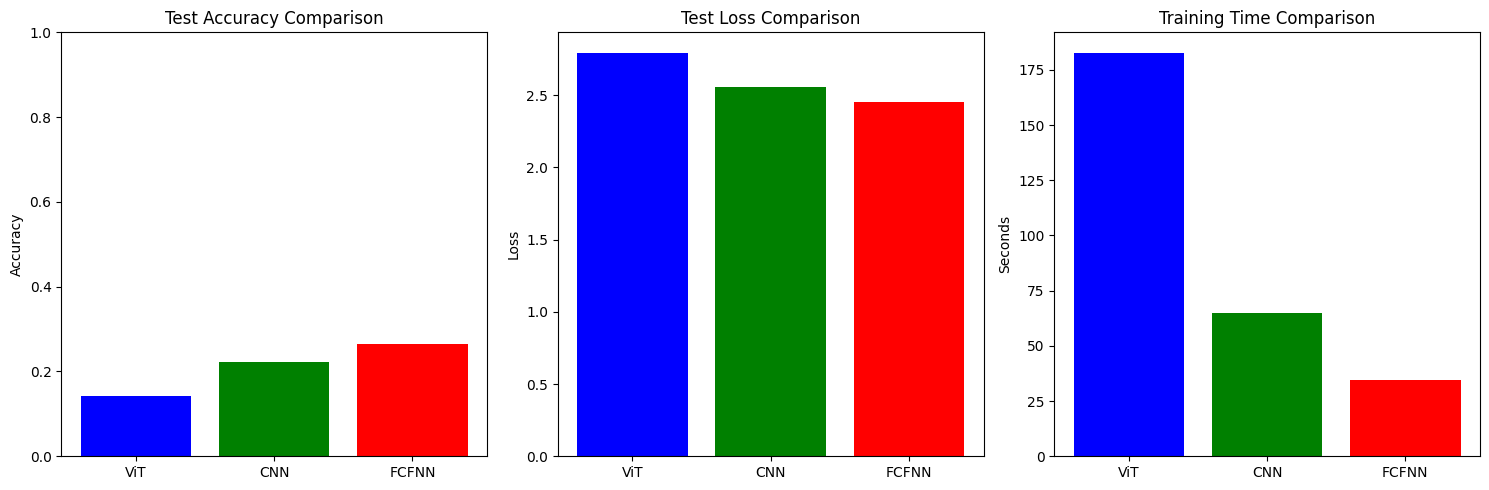

In [ ]:
print("\n===== Training Vision Transformer (ViT) =====")
vit_model = create_vit_classifier()
vit_history, vit_acc, vit_loss, vit_time = train_and_evaluate(
    vit_model, "ViT", x_train, y_train, x_val, y_val, x_test, y_test
)

print("\n===== Training CNN (ResNet50) =====")
cnn_model = create_cnn_model()
cnn_history, cnn_acc, cnn_loss, cnn_time = train_and_evaluate(
    cnn_model, "CNN", x_train, y_train, x_val, y_val, x_test, y_test
)

print("\n===== Training FCFNN =====")

fcfnn_model = create_fcfnn_model()
fcfnn_history, fcfnn_acc, fcfnn_loss, fcfnn_time = train_and_evaluate(
    fcfnn_model, "FCFNN", x_train, y_train, x_val, y_val, x_test, y_test
)

models_list = ['ViT', 'CNN', 'FCFNN']
accuracies = [vit_acc, cnn_acc, fcfnn_acc]
losses = [vit_loss, cnn_loss, fcfnn_loss]
times = [vit_time, cnn_time, fcfnn_time]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(models_list, accuracies, color=['blue', 'green', 'red'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.subplot(1, 3, 2)
plt.bar(models_list, losses, color=['blue', 'green', 'red'])
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.subplot(1, 3, 3)
plt.bar(models_list, times, color=['blue', 'green', 'red'])
plt.title('Training Time Comparison')
plt.ylabel('Seconds')
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()


===== Experimenting with Number of Heads in ViT =====

Training ViT with 2 heads...
Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 188ms/step - accuracy: 0.0638 - loss: 5.6976 - val_accuracy: 0.0810 - val_loss: 2.9289 - learning_rate: 0.0010
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.0828 - loss: 3.0379 - val_accuracy: 0.1040 - val_loss: 2.9179 - learning_rate: 0.0010
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.0846 - loss: 2.9759 - val_accuracy: 0.0970 - val_loss: 2.8941 - learning_rate: 0.0010
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.0895 - loss: 2.9321 - val_accuracy: 0.1200 - val_loss: 2.8739 - learning_rate: 0.0010
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.0987 - loss: 2.9068 - val_accuracy: 0.1160 - val_loss: 2.8625 - learning_rate: 0.0010
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.1007 - loss: 2.8946 - val_accuracy: 0.1210 - val_loss: 2.8396 - learning_rate: 

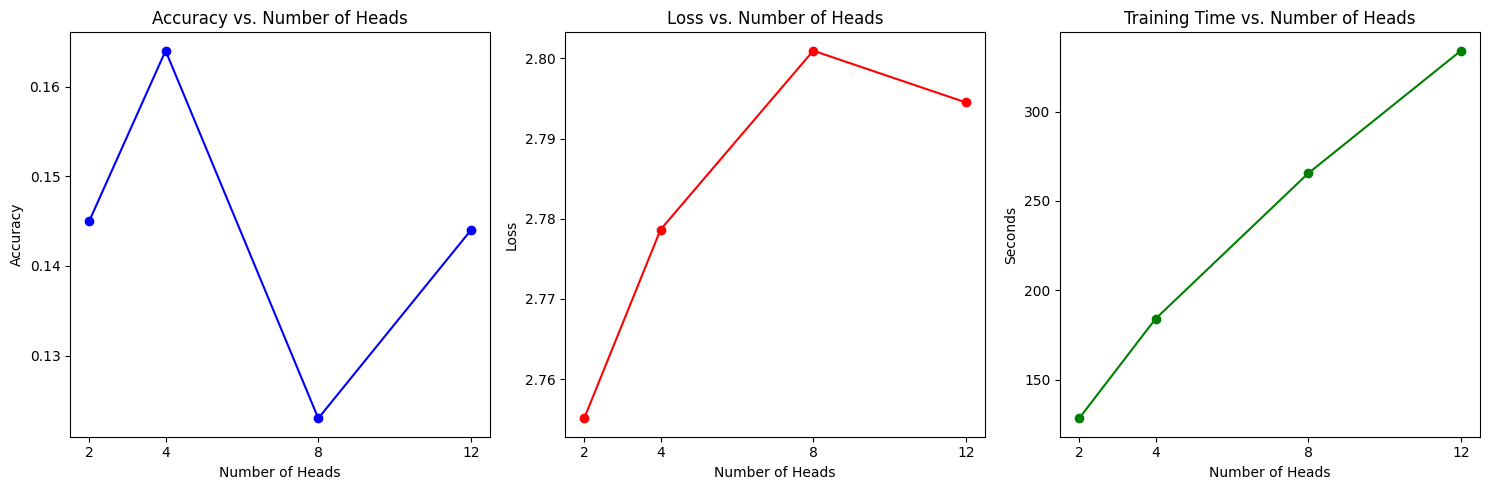

In [ ]:
num_heads_list = [2, 4, 8, 12]
head_accuracies = []
head_losses = []
head_times = []

print("\n===== Experimenting with Number of Heads in ViT =====")
for num_heads in num_heads_list:
    print(f"\nTraining ViT with {num_heads} heads...")
    vit_model = create_vit_classifier(num_heads=num_heads, num_patches=(64 // 4) ** 2)
    _, test_acc, test_loss, training_time = train_and_evaluate(
        vit_model, f"ViT-{num_heads}heads", x_train, y_train, x_val, y_val, x_test, y_test, epochs=10
    )
    head_accuracies.append(test_acc)
    head_losses.append(test_loss)
    head_times.append(training_time)

# Plotting (unchanged)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(num_heads_list, head_accuracies, 'o-', color='blue')
plt.title('Accuracy vs. Number of Heads')
plt.xlabel('Number of Heads')
plt.ylabel('Accuracy')
plt.xticks(num_heads_list)
plt.subplot(1, 3, 2)
plt.plot(num_heads_list, head_losses, 'o-', color='red')
plt.title('Loss vs. Number of Heads')
plt.xlabel('Number of Heads')
plt.ylabel('Loss')
plt.xticks(num_heads_list)
plt.subplot(1, 3, 3)
plt.plot(num_heads_list, head_times, 'o-', color='green')
plt.title('Training Time vs. Number of Heads')
plt.xlabel('Number of Heads')
plt.ylabel('Seconds')
plt.xticks(num_heads_list)
plt.tight_layout()
plt.savefig('num_heads_effect.png')
plt.show()



===== Experimenting with Patch Embedding Size in ViT =====

Training ViT with patch size 2 (1024 patches)...
Found 1000 images belonging to 20 classes.
Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 149s 812ms/step - accuracy: 0.0596 - loss: 13.1378 - val_accuracy: 0.0790 - val_loss: 2.9246 - learning_rate: 0.0010
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 588ms/step - accuracy: 0.0609 - loss: 3.0034 - val_accuracy: 0.0660 - val_loss: 2.9627 - learning_rate: 0.0010
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 141s 584ms/step - accuracy: 0.0571 - loss: 2.9839 - val_accuracy: 0.0730 - val_loss: 2.9427 - learning_rate: 0.0010
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 142s 584ms/step - accuracy: 0.0617 - loss: 2.9854 - val_accuracy: 0.0650 - val_loss: 2.9494 - learning_rate: 0.0010
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 582ms/step - accuracy: 0.0555 - loss: 2.9797 - val_accuracy: 0.0670 - val_loss: 2.9452 - learning_rate: 1.0000e-04
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 582ms/step - accurac

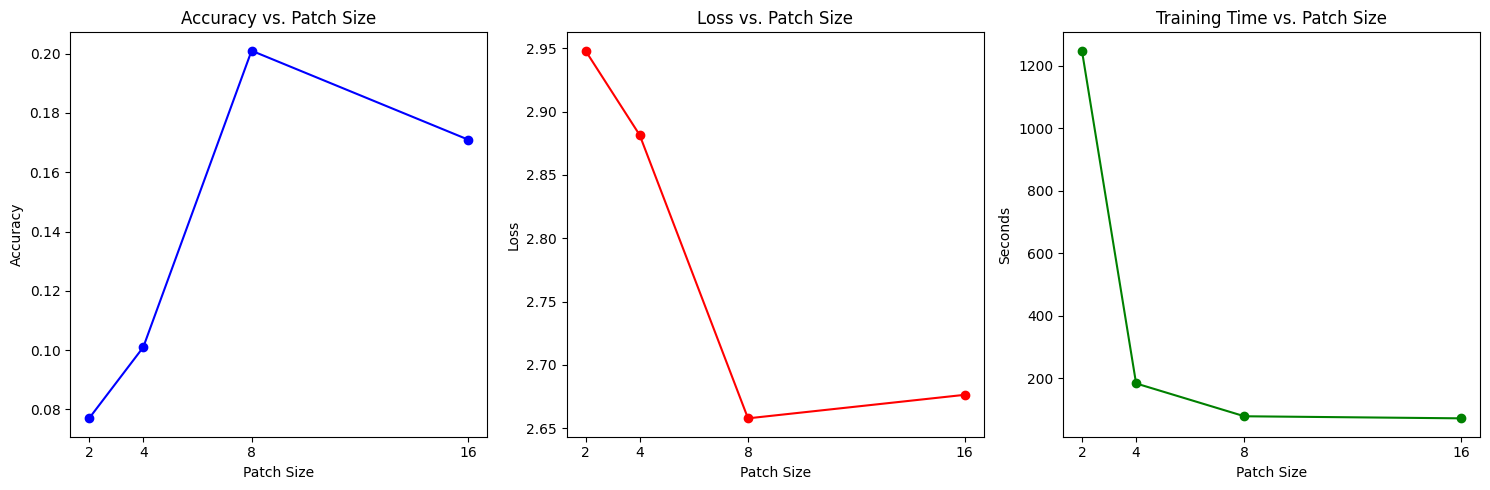

In [ ]:
patch_sizes = [2, 4, 8, 16]
patch_accuracies = []
patch_losses = []
patch_times = []

print("\n===== Experimenting with Patch Embedding Size in ViT =====")
for patch_size in patch_sizes:
    num_patches = (64 // patch_size) ** 2
    print(f"\nTraining ViT with patch size {patch_size} ({num_patches} patches)...")

   
    current_test_batch_size = 32
    if patch_size < 4:
        current_test_batch_size = 16
        test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
        test_generator = test_datagen.flow_from_directory(
            '/content/imagenet_20/val',
            target_size=(64, 64),
            batch_size=current_test_batch_size,
            class_mode='categorical',
            shuffle=False
        )

        x_test, y_test = generator_to_arrays(test_generator)


    vit_model = create_vit_classifier(patch_size=patch_size, num_patches=num_patches)
    _, test_acc, test_loss, training_time = train_and_evaluate(
        vit_model, f"ViT-patch{patch_size}", x_train, y_train, x_val, y_val, x_test, y_test, epochs=10
    )
    patch_accuracies.append(test_acc)
    patch_losses.append(test_loss)
    patch_times.append(training_time)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(patch_sizes, patch_accuracies, 'o-', color='blue')
plt.title('Accuracy vs. Patch Size')
plt.xlabel('Patch Size')
plt.ylabel('Accuracy')
plt.xticks(patch_sizes)
plt.subplot(1, 3, 2)
plt.plot(patch_sizes, patch_losses, 'o-', color='red')
plt.title('Loss vs. Patch Size')
plt.xlabel('Patch Size')
plt.ylabel('Loss')
plt.xticks(patch_sizes)
plt.subplot(1, 3, 3)
plt.plot(patch_sizes, patch_times, 'o-', color='green')
plt.title('Training Time vs. Patch Size')
plt.xlabel('Patch Size')
plt.ylabel('Seconds')
plt.xticks(patch_sizes)
plt.tight_layout()
plt.savefig('patch_size_effect.png')
plt.show()


===== Experimenting with Positional Embedding Type in ViT =====

Training ViT with learned positional embedding...
Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 194ms/step - accuracy: 0.0625 - loss: 5.5852 - val_accuracy: 0.0780 - val_loss: 2.9805 - learning_rate: 0.0010
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.0643 - loss: 3.0759 - val_accuracy: 0.0970 - val_loss: 2.9290 - learning_rate: 0.0010
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.0777 - loss: 2.9996 - val_accuracy: 0.0940 - val_loss: 2.9396 - learning_rate: 0.0010
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.0862 - loss: 2.9573 - val_accuracy: 0.1160 - val_loss: 2.8867 - learning_rate: 0.0010
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.0998 - loss: 2.9316 - val_accuracy: 0.1220 - val_loss: 2.8811 - learning_rate: 0.0010
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.1081 - loss: 2.8930 - val_accuracy: 0.1350 - val

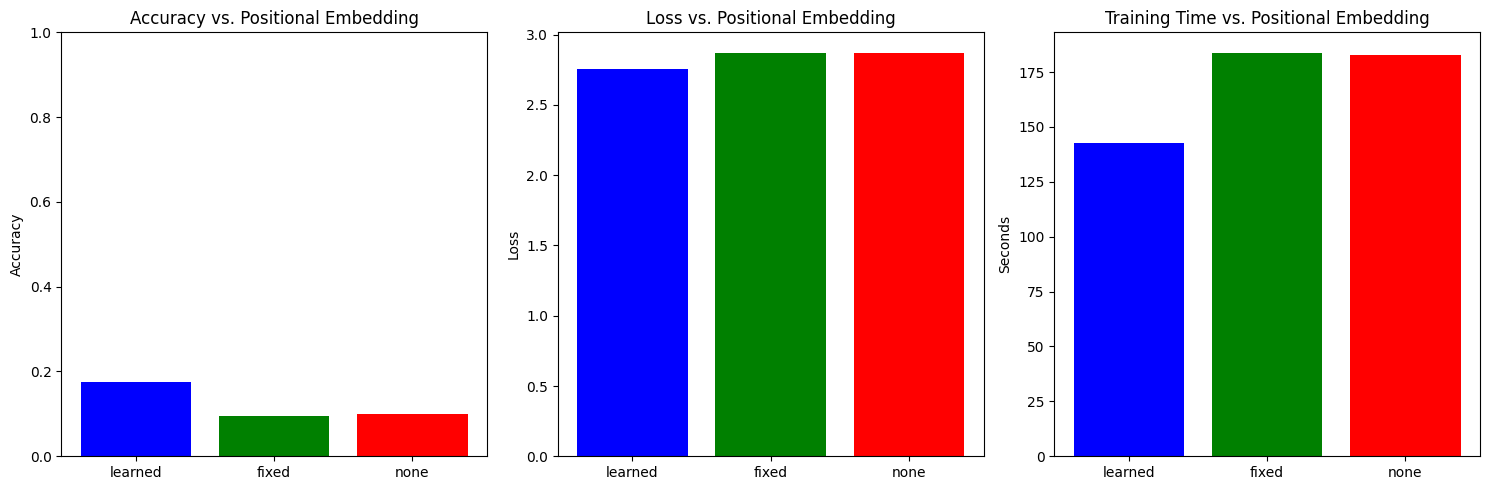

In [ ]:
class PatchEncoderWithOption(layers.Layer):
    def __init__(self, num_patches, projection_dim, embedding_type="learned", **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.embedding_type = embedding_type

        self.projection = layers.Dense(units=projection_dim)

        if embedding_type == "learned":

            self.position_embedding = layers.Embedding(
                input_dim=num_patches, output_dim=projection_dim
            )

        elif embedding_type == "fixed":
            positions = tf.range(start=0, limit=num_patches, delta=1)
            sinusoidal_pe = self._sinusoidal_encoding(positions, projection_dim)
            self.position_embedding = tf.constant(sinusoidal_pe, dtype=tf.float32)

        elif embedding_type == "none":
            self.position_embedding = None

        else:
            raise ValueError(f"Unknown embedding_type: {embedding_type}")

    def _sinusoidal_encoding(self, positions, dim):
        """Generates sinusoidal positional encoding."""
        angle_rates = 1 / tf.pow(
            10000, (2 * (tf.cast(tf.range(dim), tf.float32) // 2)) / tf.cast(dim, tf.float32)
        )
        angle_rads = tf.cast(positions, tf.float32)[:, tf.newaxis] * angle_rates[tf.newaxis, :]
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.reshape(
            tf.stack([sines, cosines], axis=-1),
            [tf.shape(positions)[0], dim]
        )
        return pos_encoding

    def call(self, patch):
        projected = self.projection(patch)
        projected.set_shape((None, self.num_patches, self.projection_dim)) 
        if self.embedding_type == "none":
            return projected

        elif self.embedding_type == "learned":
            positions = tf.range(start=0, limit=self.num_patches, delta=1)
            return projected + self.position_embedding(positions)

        elif self.embedding_type == "fixed":
            batch_size = tf.shape(patch)[0]
            pos_emb = tf.expand_dims(self.position_embedding, 0) 
            pos_emb = tf.tile(pos_emb, [batch_size, 1, 1])
            return projected + pos_emb




def create_vit_classifier_with_pos_embedding(
    input_shape=(64, 64, 3), 
    patch_size=4,
    num_patches=(64 // 4) ** 2,
    projection_dim=64,
    num_heads=4,
    transformer_layers=4,
    mlp_head_units=[128, 64],
    num_classes=20,
    positional_embedding_type="learned"
):
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoderWithOption(
        num_patches, projection_dim, positional_embedding_type
    )(patches)
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=mlp_head_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

embedding_types = ["learned", "fixed", "none"]
embedding_accuracies = []
embedding_losses = []
embedding_times = []

print("\n===== Experimenting with Positional Embedding Type in ViT =====")
for embedding_type in embedding_types:
    print(f"\nTraining ViT with {embedding_type} positional embedding...")
    vit_model = create_vit_classifier_with_pos_embedding(positional_embedding_type=embedding_type)
    _, test_acc, test_loss, training_time = train_and_evaluate(
        vit_model, f"ViT-{embedding_type}", x_train, y_train, x_val, y_val, x_test, y_test, epochs=10
    )
    embedding_accuracies.append(test_acc)
    embedding_losses.append(test_loss)
    embedding_times.append(training_time)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(embedding_types, embedding_accuracies, color=['blue', 'green', 'red'])
plt.title('Accuracy vs. Positional Embedding')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.subplot(1, 3, 2)
plt.bar(embedding_types, embedding_losses, color=['blue', 'green', 'red'])
plt.title('Loss vs. Positional Embedding')
plt.ylabel('Loss')
plt.subplot(1, 3, 3)
plt.bar(embedding_types, embedding_times, color=['blue', 'green', 'red'])
plt.title('Training Time vs. Positional Embedding')
plt.ylabel('Seconds')
plt.tight_layout()
plt.savefig('positional_embedding_effect.png')
plt.show()